In [1]:
# Uso de GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Detalles:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
Detalles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Importaciones generales
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2, VGG16, MobileNetV2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
# Configuraciones globales
BASE_DIR = r'C:\Users\oicas\OneDrive\Desktop\Intro a las App de Algoritmos de ML y DL\Proyecto\Dataset\dataset_proyecto_final'
IMG_SIZE = 224 #
BATCH_SIZE = 64 #32, 64 o 128
SEED = 42 #

In [4]:
# Limpieza de imágenes corruptas
def limpiar_imagenes(directorio):
    n_borradas = 0
    n_procesadas = 0    
    for root, dirs, files in os.walk(directorio):
        for file in files:
            ruta_img = os.path.join(root, file)
            try:
                img = cv2.imread(ruta_img) 
                if img is None:
                    print(f"[BORRADO] Imagen corrupta: {file}")
                    os.remove(ruta_img)
                    n_borradas += 1                
                n_procesadas += 1
                if n_procesadas % 100 == 0:
                    print(".", end="")                    
            except Exception as e:
                print(f"\n[ERROR] Fallo en {file}: {e}")
    print(f"Imágenes revisadas: {n_procesadas}")
    print(f"Imágenes borradas: {n_borradas}")
limpiar_imagenes(BASE_DIR)

..........................................................................................................................Imágenes revisadas: 12274
Imágenes borradas: 0


C:\Users\oicas\AppData\Local\Temp\ipykernel_13300\1186024139.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


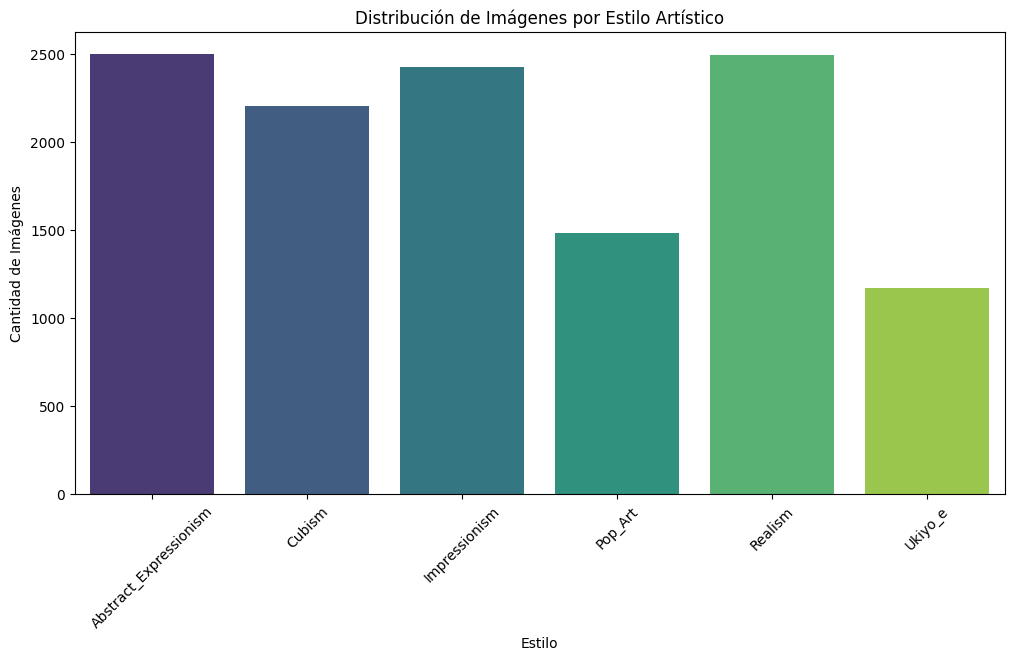

Total de clases: 6
Total de imágenes: 12274


In [5]:
# Análisis de la distribución de clases
classes = os.listdir(BASE_DIR)
counts = []

for c in classes:
    path = os.path.join(BASE_DIR, c)
    if os.path.isdir(path):
        counts.append(len(os.listdir(path)))

# Visualizacion de la distribución
plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=counts, palette="viridis")
plt.title("Distribución de Imágenes por Estilo Artístico")
plt.xlabel("Estilo")
plt.ylabel("Cantidad de Imágenes")
plt.xticks(rotation=45)
plt.show()

# Resumen de la distribución
print(f"Total de clases: {len(classes)}")
print(f"Total de imágenes: {sum(counts)}")

In [6]:
# Generador de Entrenamiento y Validacion con Aumento de Datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,          
    horizontal_flip=True,
    brightness_range=[0.8, 1.2], 
    channel_shift_range=20.0,    
    fill_mode='nearest',
    validation_split=0.2
)

# Entrenamiento 
train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    shuffle=True
)

# Generador de Validacion 
validation_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False # False para poder evaluar ordenadamente al final
)

# Mostrar las clases detectadas
class_names = list(train_generator.class_indices.keys())
print("Clases detectadas:", class_names)

Found 9822 images belonging to 6 classes.
Found 2452 images belonging to 6 classes.
Clases detectadas: ['Abstract_Expressionism', 'Cubism', 'Impressionism', 'Pop_Art', 'Realism', 'Ukiyo_e']


In [7]:
# Calculo de pesos de clase para manejar el desbalanceo
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Pesos de clase: {class_weights_dict}")

Pesos de clase: {0: 0.8185, 1: 0.9285309132161089, 2: 0.8429454170957775, 3: 1.37910699241786, 4: 0.8201402805611222, 5: 1.7526766595289078}


In [8]:
# Funciones construcoras de modelos
# Descarga de las bases modelos
def obtener_backbone(nombre, input_shape):
    if nombre == 'resnet50':
        return ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif nombre == 'vgg16':
        return VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif nombre == 'mobilenet':
        return MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Modelo {nombre} no soportado")

# Ensamble del modelo completo
def construir_modelo(nombre_backbone, num_clases, dropout_rate=0.5, learning_rate=0.001):
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    
    # Base
    base_model = obtener_backbone(nombre_backbone, input_shape)
    base_model.trainable = False # Congelar inicialmente
    
    # Cabeza (Top)
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate / 2),
        Dense(num_clases, activation='softmax')
    ])
    
    # Compilación del modelo
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    # Ensamble del modelo completo
    return model, base_model

In [9]:
# Lista de experimentos a correr
experimentos_dl = [
    # Prueba rápida con MobileNet (ligero)
    {'nombre': 'MobileNet_Base', 'backbone': 'mobilenet', 'fine_tuning': False, 'dropout': 0.5},
    # Prueba con VGG16 (clásico)
    {'nombre': 'VGG16_Base',     'backbone': 'vgg16',     'fine_tuning': False, 'dropout': 0.5},
    # Tu preprobado (ResNet50 Base)
    {'nombre': 'ResNet50_Base',  'backbone': 'resnet50',  'fine_tuning': False, 'dropout': 0.6},
    # Modelo Avanzado (ResNet50 + Fine Tuning)
    {'nombre': 'ResNet50_FT',    'backbone': 'resnet50',  'fine_tuning': True,  'dropout': 0.5}, 
]

resultados_globales = []

In [10]:
print(f"\n Iniciando ronda de {len(experimentos_dl)} experimentos (DL)")

# Configuración de Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Execución de experimentos
for exp in experimentos_dl:
    print(f"\n Ejecutando {exp['nombre']}")
    tf.keras.backend.clear_session() # Limpiar memoria
    start_time = time.time()
    
    # Construccion
    model, base_model = construir_modelo(
        exp['backbone'], 
        len(class_names), 
        dropout_rate=exp['dropout']
    )
    
    # Entrenar Fase 1 (Congelado)
    print("Transfer Learning (Congelado)")
    history = model.fit(
        train_generator,
        epochs=17, #
        validation_data=validation_generator,
        class_weight=class_weights_dict,
        callbacks=[early_stop],
        verbose=1 # Mostrar barra de progreso
    )
    
    final_acc = history.history['val_accuracy'][-1]
    
    # Entrenar Fase 2 (Fine Tuning)
    if exp['fine_tuning']:
        print("Fine Tuning (Descongelando capas)")
        base_model.trainable = True
        # Descongelar últimas capas (aprox 20% final)
        limit = int(len(base_model.layers) * 0.8)
        for layer in base_model.layers[:limit]:
            layer.trainable = False
            
        # Re-compilar con LR muy bajo
        model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
        
        history_ft = model.fit(
            train_generator,
            epochs=17, #
            validation_data=validation_generator,
            class_weight=class_weights_dict,
            callbacks=[early_stop],
            verbose=1
        )
        final_acc = history_ft.history['val_accuracy'][-1]
        
    duration = time.time() - start_time
    
    # Guardar métricas
    resultados_globales.append({
        'Modelo': exp['nombre'],
        'Tipo': 'Deep Learning',
        'Backbone': exp['backbone'],
        'FineTuning': exp['fine_tuning'],
        'Val_Accuracy': final_acc,
        'Tiempo_Seg': round(duration, 2)
    })
    
    # Guardar modelo si es el mejor hasta ahora
    model.save(f"modelo_{exp['nombre']}.h5")


 Iniciando ronda de 4 experimentos (DL)

 Ejecutando MobileNet_Base
Transfer Learning (Congelado)
Epoch 1/17
154/154 [==============================] - 278s 2s/step - loss: 3.8958 - accuracy: 0.5092 - val_loss: 2.5049 - val_accuracy: 0.5440
Epoch 2/17
154/154 [==============================] - 282s 2s/step - loss: 1.9427 - accuracy: 0.5996 - val_loss: 1.5696 - val_accuracy: 0.6044
Epoch 3/17
154/154 [==============================] - 419s 3s/step - loss: 1.4486 - accuracy: 0.6141 - val_loss: 1.3894 - val_accuracy: 0.6126
Epoch 4/17
154/154 [==============================] - 274s 2s/step - loss: 1.3042 - accuracy: 0.6115 - val_loss: 1.2253 - val_accuracy: 0.6444
Epoch 5/17
154/154 [==============================] - 402s 3s/step - loss: 1.2188 - accuracy: 0.6211 - val_loss: 1.1746 - val_accuracy: 0.6395
Epoch 6/17
154/154 [==============================] - 283s 2s/step - loss: 1.1935 - accuracy: 0.6189 - val_loss: 1.1662 - val_accuracy: 0.6134
Epoch 7/17
154/154 [=======================

KeyboardInterrupt: 

In [ ]:
# Unir las historias
acc = history.history['accuracy'] + history_ft.history['accuracy']
val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history.history['loss'] + history_ft.history['loss']
val_loss = history.history['val_loss'] + history_ft.history['val_loss']

plt.figure(figsize=(12, 6))

# Gráfico de Precisión
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Línea vertical donde empieza el Fine Tuning
plt.axvline(x=len(history.history['accuracy']), color='green', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Evolución de la Precisión')
plt.legend()

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['loss']), color='green', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Evolución del Error (Loss)')
plt.legend()

plt.show()

In [ ]:
print("\n Iniciando experimentacion hibrida (Feats + ML)")

# ResNet50 para extraer características por ser robusto
try:
    tf.keras.backend.clear_session()

    # Extracción de características
    base_feat = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    extractor = Sequential([base_feat, GlobalAveragePooling2D()])
    
    # Generador de Entrenamiento SIN mezcla (Ordenado alfabéticamente)
    gen_train_feat = train_datagen.flow_from_directory(
        BASE_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        seed=SEED,
        shuffle=False
    )
    
    # Generador de Validación SIN mezcla
    gen_val_feat = train_datagen.flow_from_directory(
        BASE_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        seed=SEED,
        shuffle=False
    )
    
    print("Extrayendo características de entrenamiento")
    # USAR gen_train_feat (el que tiene shuffle=False)
    X_train = extractor.predict(gen_train_feat, verbose=1) 
    y_train = gen_train_feat.classes

    print("Extrayendo características de validación")
    # USAR gen_val_feat
    X_val = extractor.predict(gen_val_feat, verbose=1)
    y_val = gen_val_feat.classes
    print(f"Características extraídas: Train {X_train.shape}, Val {X_val.shape}")
    
    # Modelos clásicos a probar
    clasificadores = {
        'SVM_RBF': SVC(kernel='rbf', C=1.0),
        'RandomForest_100': RandomForestClassifier(n_estimators=100, random_state=SEED)
    }
    
    # Entrenamiento y evaluación de clasificadores clásicos
    for nombre_clf, clf in clasificadores.items():
        print(f"Entrenando {nombre_clf}")
        start_t = time.time()
        
        # Entrenar clasificador
        clf.fit(X_train, y_train)
        preds = clf.predict(X_val)
        acc = accuracy_score(y_val, preds)
        
        # Medir duración
        dur = time.time() - start_t

        print(f"{nombre_clf} Accuracy: {acc:.4f}")
        
        # Guardar métricas
        resultados_globales.append({
            'Modelo': f"Hibrido_ResNet_{nombre_clf}",
            'Tipo': 'ML Clásico',
            'Backbone': 'ResNet50 (Feats)',
            'FineTuning': False,
            'Val_Accuracy': acc,
            'Tiempo_Seg': round(dur, 2)
        })

# Guardar modelo si es el mejor hasta ahora
except Exception as e:
    print(f"Error en fase híbrida: {e}")

In [ ]:
print("\nExperimento Hibrido con Fine-Tuning")

nombre_modelo_ft = "modelo_ResNet50_FT.h5"

# Verificar modelo guardado
if not os.path.exists(nombre_modelo_ft):
    print(f"No se encontró el archivo '{nombre_modelo_ft}'.")
else:
    try:
        tf.keras.backend.clear_session()
        
        # Cargar el modelo ya entrenado
        print(f"Cargando modelo entrenado: {nombre_modelo_ft}...")
        modelo_ft = load_model(nombre_modelo_ft)
        
        # Crear el extractor
        # Salida de la capa de Pooling
        try:
            layer_output = modelo_ft.get_layer('global_average_pooling2d').output
        except:
            layer_output = modelo_ft.layers[-5].output
            
        extractor_ft = Model(inputs=modelo_ft.input, outputs=layer_output)
        print("Extractor construido con éxito. Los 'ojos' de la red ya saben de arte.")

        # Generadores ordenados
        print("Generando datos ordenados para la fase avanzada...")
        gen_train_ft = train_datagen.flow_from_directory(
            BASE_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
            class_mode='categorical', subset='training', seed=SEED, shuffle=False
        )
        gen_val_ft = train_datagen.flow_from_directory(
            BASE_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
            class_mode='categorical', subset='validation', seed=SEED, shuffle=False
        )

        # Extraer características
        print("Extrayendo características refinadas (Train)...")
        X_train_ft = extractor_ft.predict(gen_train_ft, verbose=1)
        y_train_ft = gen_train_ft.classes
        
        print("Extrayendo características refinadas (Val)...")
        X_val_ft = extractor_ft.predict(gen_val_ft, verbose=1)
        y_val_ft = gen_val_ft.classes
        
        # Entrenar SVM con estos datos de alta calidad
        print("Entrenando SVM (RBF) con características Fine-Tuned...")
        start_t = time.time()
        
        svm_ft = SVC(kernel='rbf', C=1.0)
        svm_ft.fit(X_train_ft, y_train_ft)
        
        # Evaluar
        preds_ft = svm_ft.predict(X_val_ft)
        acc_ft = accuracy_score(y_val_ft, preds_ft)
        
        dur = time.time() - start_t
        print(f"--> RESULTADO FINAL (Fine-Tuning + SVM): {acc_ft:.2%}")
        
        # Tabla de resultados global
        resultados_globales.append({
            'Modelo': 'Hibrido_FT_SVM_RBF', # Nombre distintivo
            'Tipo': 'Híbrido Avanzado',
            'Backbone': 'ResNet50 (FineTuned)',
            'FineTuning': True,
            'Val_Accuracy': acc_ft,
            'Tiempo_Seg': round(dur, 2)
        })

    except Exception as e:
        print(f"Error en el experimento avanzado: {e}")

In [ ]:
# Resultados finales
df_res = pd.DataFrame(resultados_globales)
df_res = df_res.sort_values(by='Val_Accuracy', ascending=False).reset_index(drop=True)

In [ ]:
# Mostrar tabla comparativa
print("\nTABLA COMPARATIVA DE MODELOS:")
display(df_res) 

In [ ]:
# Visualización de resultados
plt.figure(figsize=(14, 7))
sns.barplot(x='Val_Accuracy', y='Modelo', data=df_res, hue='Tipo', palette='viridis')
plt.title(f'Comparativa de Precisión (Accuracy) en Validación - {len(df_res)} Modelos')
plt.xlabel('Accuracy (0.0 - 1.0)')
plt.xlim(0, 1.05)
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
for index, value in enumerate(df_res['Val_Accuracy']):
    plt.text(value, index, f'{value:.2%}', va='center')
plt.show()

In [ ]:
mejor_modelo = df_res.iloc[0]
print(f"EL MEJOR MODELO ES: {mejor_modelo['Modelo']}")
print(f"Precisión: {mejor_modelo['Val_Accuracy']:.2%}")